In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
cur_path = "./drive/Othercomputers/Vivian's MacBook Pro 2021/DS5720/FinalProject"
os.chdir(cur_path)
!pwd

Mounted at /content/drive
/content/drive/Othercomputers/Vivian's MacBook Pro 2021/DS5720/FinalProject


In [2]:
! pip install dgl
! pip uninstall umap
! pip install umap-learn
import dgl
import torch
import pandas as pd 
import umap.umap_ as umap

     |████████████████████████████████| 4.4 MB 3.7 MB/s 
     |████████████████████████████████| 88 kB 3.6 MB/s 
     |████████████████████████████████| 1.1 MB 23.3 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=213deecf33de83c82d6a91896310a4775bb30345374af010fb9731c2b66aa1f7
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=b506bb9e51fa3323b9567613ab5820bd666e2f94f6ae273b42c115e87878327c
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent
Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


# 1. Data Import

In [26]:
task = pd.read_csv("./data/task2/train-v0.2.csv")
mega_table = pd.read_csv("./data/product_catalogue-v0.2.csv")
merged_df = pd.merge(task, mega_table, how = 'left', left_on = ['product_id', 'query_locale'], right_on = ['product_id', 'product_locale'])
query_embed = pd.read_csv("./data/us50k_query_embedding.csv")
product_title_embed = pd.read_csv("./data/us50k_product_title_embedding.csv")

In [27]:
merged_df = merged_df[merged_df['product_locale'] == 'us']
merged_df = merged_df.fillna('')

## 1.1 Get nodes

In [28]:
# query_embed = pd.read_csv("./data/query_2d_embedding.csv")
query_embed = pd.merge(query_embed, pd.DataFrame(merged_df['query'].unique(), columns=['Query']), on = 'Query').drop(columns=['Unnamed: 0'])
query_embed.insert(0, 'query_id', range(0, 0 + len(query_embed)))
query_embed['combined']=query_embed.drop(columns=['query_id', 'Query']).values.tolist()
query_embed = query_embed[['query_id', 'Query', 'combined']]
query_embed

,query_id,Query,combined
0,0,revent 80 cfm,"[0.3772154, 0.28850505, 0.9209312, -0.11552514..."
1,1,# 2 pencils not sharpened,"[0.2370911, 0.19300619, 0.19530456, -0.4864252..."
2,2,# do not disturb,"[0.39659384, 0.44133782, 0.66782707, -0.936925..."
3,3,# mom life,"[0.98151696, 0.5753808, 0.9085639, 0.32715052,..."
4,4,# sharp not hashtag shirt,"[0.7096678, 0.5629531, 0.21123986, -0.5959373,..."
...,...,...,...
2616,2616,ac milan leather,"[0.6984452, 0.16217867, 0.6510631, 0.31046593,..."
2617,2617,ac powerbank,"[0.6807513, -0.3814727, 0.21798177, 0.721333, ..."
2618,2618,ac recharge kit,"[0.617627, -0.061278045, 0.39211014, 0.9004252..."
2619,2619,ac split unit,"[0.7279886, -0.46039385, 0.085269734, 0.591594..."


In [25]:
product_title_embed = pd.read_csv("./data/product_2d_embedding.csv")
product_title_embed = product_title_embed.drop_duplicates()
merged_df['product'] = merged_df['product_title'] +  merged_df['product_description'] +  merged_df['product_bullet_point'] +  merged_df['product_brand'] +  merged_df['product_color_name']
product_title_embed = pd.merge(product_title_embed, pd.DataFrame(merged_df['product'].unique(), columns=['Product']), on = 'Product').drop(columns=['Unnamed: 0'])
product_title_embed.insert(0, 'product_id', range(0, 0 + len(product_title_embed)))
product_title_embed['combined']=product_title_embed.drop(columns=['product_id', 'Product']).values.tolist()
product_title_embed = product_title_embed[['product_id', 'Product', 'combined']]
product_title_embed

ParserError: ignored

In [29]:
product_title_embed = pd.merge(product_title_embed, pd.DataFrame(merged_df['product_title'].unique(), columns=['Product']), on = 'Product').drop(columns=['Unnamed: 0'])
product_title_embed.insert(0, 'product_id', range(0, 0 + len(product_title_embed)))
product_title_embed['combined']=product_title_embed.drop(columns=['product_id', 'Product']).values.tolist()
product_title_embed = product_title_embed[['product_id', 'Product', 'combined']]
product_title_embed

,product_id,Product,combined
0,0,Panasonic FV-20VQ3 WhisperCeiling 190 CFM Ceil...,"[0.5584528, -0.115527354, 0.989929, 0.5647745,..."
1,1,"Broan Very Quiet Ceiling Bathroom Exhaust Fan,...","[0.42908123, -0.01130617, 0.78302675, 0.889836..."
2,2,Delta BreezSignature VFB25ACH 80 CFM Exhaust B...,"[0.55030024, -0.13049354, 1.067971, 0.76725423..."
3,3,Aero Pure AP80RVLW Super Quiet 80 CFM Recessed...,"[0.6489395, -0.2732966, 0.9358898, 0.7858058, ..."
4,4,Panasonic FV-0811VF5 WhisperFit EZ Retrofit Ve...,"[0.4358175, 0.096745856, 0.88996965, 0.4098112..."
...,...,...,...
45195,45195,"Cooper & Hunter 9,000 BTU, 115V, 19 SEER Ductl...","[0.5811683, -0.07111953, 0.8577781, 0.7198514,..."
45196,45196,"DELLA 12,000 BTU Mini Split Air Conditioner Du...","[0.41857454, -0.14850773, 0.40461016, 0.960956..."
45197,45197,"Emerson Quiet Kool 5,000 BTU 115V Window Air C...","[0.4760484, 0.12030364, 0.99494934, 0.6027467,..."
45198,45198,"JHS 10,000 BTU Portable Air Conditioner 3-in-1...","[0.36931574, -0.062436827, 0.7381011, 0.826377..."


## 1.2 Get edges

In [30]:
cleaned_df = merged_df[merged_df['product_locale'] == 'us'][['query', 'product_title', 'esci_label']][:50000]
temp_merged = pd.merge(cleaned_df, query_embed, left_on = ['query'], right_on = ['Query'], how = 'left')
total_index = pd.merge(temp_merged, product_title_embed, left_on = ['product_title'], right_on = ['Product'], how = 'left', suffixes = ('_query', '_product') )
total_index = total_index.dropna()
# total_index
query_idx = total_index[['query_id', 'query', 'combined_query', 'esci_label']]
product_idx = total_index[['product_id', 'product_title', 'combined_product', 'esci_label']]


In [31]:
i_edge_q = query_idx[query_idx['esci_label'] == 'irrelevant']
i_edge_p = product_idx[product_idx['esci_label'] == 'irrelevant']
i_edge_idx = [i_edge_q['query_id'].tolist(), i_edge_p['product_id'].tolist()]

e_edge_q = query_idx[query_idx['esci_label'] == 'exact']
e_edge_p = product_idx[product_idx['esci_label'] == 'exact']
e_edge_idx = [e_edge_q['query_id'].tolist(), e_edge_p['product_id'].tolist()]

c_edge_q = query_idx[query_idx['esci_label'] == 'complement']
c_edge_p = product_idx[product_idx['esci_label'] == 'complement']
c_edge_idx = [c_edge_q['query_id'].tolist(), c_edge_p['product_id'].tolist()]


s_edge_q = query_idx[query_idx['esci_label'] == 'substitute']
s_edge_p = product_idx[product_idx['esci_label'] == 'substitute']
s_edge_idx = [s_edge_q['query_id'].tolist(), s_edge_p['product_id'].tolist()]


# 2. Create Graph

In [32]:
graph_data = {
   ('query', 'irrelevant', 'product'): (torch.tensor(i_edge_idx[0], dtype=torch.int32), torch.tensor(i_edge_idx[1], dtype=torch.int32)),
   ('query', 'exact', 'product'): (torch.tensor(e_edge_idx[0], dtype=torch.int32), torch.tensor(e_edge_idx[1], dtype=torch.int32)),
   ('query', 'complement', 'product'): (torch.tensor(c_edge_idx[0], dtype=torch.int32), torch.tensor(c_edge_idx[1], dtype=torch.int32)),
   ('query', 'substitute', 'product'): (torch.tensor(s_edge_idx[0], dtype=torch.int32), torch.tensor(s_edge_idx[1], dtype=torch.int32))
}
qp_graph = dgl.heterograph(graph_data)

In [33]:
qp_graph

Graph(num_nodes={'product': 45200, 'query': 2621},
      num_edges={('query', 'complement', 'product'): 1149, ('query', 'exact', 'product'): 29903, ('query', 'irrelevant', 'product'): 5851, ('query', 'substitute', 'product'): 13094},
      metagraph=[('query', 'product', 'complement'), ('query', 'product', 'exact'), ('query', 'product', 'irrelevant'), ('query', 'product', 'substitute')])

In [34]:
qp_graph.nodes['query'].data['embed'] = torch.tensor(query_embed['combined'].tolist())
qp_graph.nodes['product'].data['embed'] = torch.tensor(product_title_embed['combined'].tolist())

In [12]:
import gc

del task
del mega_table
del merged_df
del cleaned_df

gc.collect()

3707

# 3. Train a model

In [35]:
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F

class RGCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, rel_names):
        super().__init__()

        self.conv1 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(in_feats, hid_feats)
            for rel in rel_names}, aggregate='sum')
        self.conv2 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(hid_feats, out_feats)
            for rel in rel_names}, aggregate='sum')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = {k: F.relu(v) for k, v in h.items()}
        h = self.conv2(graph, h)
        return h

class HeteroMLPPredictor(nn.Module):
    def __init__(self, in_dims, n_classes):
        super().__init__()
        self.W = nn.Linear(in_dims * 2, n_classes)

    def apply_edges(self, edges):
        x = torch.cat([edges.src['embed'], edges.dst['embed']], 1)
        y = self.W(x)
        return {'score': y}

    def forward(self, graph, h):
        # h contains the node representations for each edge type computed from
        # the GNN for heterogeneous graphs defined in the node classification
        # section (Section 5.1).
        with graph.local_scope():
            graph.ndata['h'] = h   # assigns 'h' of all node types in one shot
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, rel_names):
        super().__init__()
        self.sage = RGCN(in_features, hidden_features, out_features, rel_names)
        self.pred = HeteroMLPPredictor(out_features, len(rel_names))
    def forward(self, g, x, dec_graph):
        h = self.sage(g, x)
        return self.pred(dec_graph, h)

In [36]:
dec_graph = qp_graph['query', :, 'product']
edge_label = torch.tensor(dec_graph.edata[dgl.ETYPE], dtype=torch.long)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [37]:
dec_graph.edata['train_mask'] = torch.zeros(dec_graph.num_edges('complement+exact+irrelevant+substitute'), dtype=torch.bool).bernoulli(0.7)
dec_graph.edata['val_mask'] = torch.tensor([not x for x in dec_graph.edata['train_mask'] ], dtype=torch.bool)

In [38]:
train_mask = dec_graph.edata['train_mask']
val_mask = dec_graph.edata['val_mask']

In [17]:
! pip install torchmetrics

     |████████████████████████████████| 409 kB 4.2 MB/s 


In [39]:
from torchmetrics import F1Score, Accuracy

model = Model(768, 1536, 768, qp_graph.etypes)
query_feats = qp_graph.nodes['query'].data['embed']
product_feats = qp_graph.nodes['product'].data['embed']
node_features = {'query': query_feats, 'product': product_feats}



acc_list = []
f1_w = []
f1_m = []

opt = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(2000):
    model.train()
    logits = model(qp_graph, node_features, dec_graph)
    loss = F.cross_entropy(logits[train_mask], edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(f"Epoch: {epoch}, Training Loss = {loss.item()}")

    if epoch % 10 == 0:
      model.eval()
      with torch.no_grad():
          logits = model(qp_graph, node_features, dec_graph)
          logits = logits[val_mask]
          labels = edge_label[val_mask]
          _, indices = torch.max(logits, dim=1)
          correct = torch.sum(indices == labels)
          f1 = F1Score(num_classes=4, average = 'weighted')
          f1_weighted = f1(indices, labels)
          f1 = F1Score(num_classes=4, average = 'macro')
          f1_macro = f1(indices, labels)
          accuracy = Accuracy()
          acc = accuracy(indices, labels)
          acc_list.append(acc.item())
          f1_w.append(f1_weighted.item())
          f1_m.append(f1_macro.item())
          print("Accuracy = ", acc.item(), "F1 weighted = ", f1_weighted.item(), "F1 macro = ", f1_macro.item())

Epoch: 0, Training Loss = 1.559446930885315
Accuracy =  0.3249207139015198 F1 weighted =  0.29264530539512634 F1 macro =  0.19230948388576508
Epoch: 1, Training Loss = 1.2670763731002808
Epoch: 2, Training Loss = 1.0849097967147827
Epoch: 3, Training Loss = 1.0332164764404297
Epoch: 4, Training Loss = 1.0482177734375
Epoch: 5, Training Loss = 1.062922477722168
Epoch: 6, Training Loss = 1.060956358909607
Epoch: 7, Training Loss = 1.0496364831924438
Epoch: 8, Training Loss = 1.041958212852478
Epoch: 9, Training Loss = 1.0422724485397339
Epoch: 10, Training Loss = 1.0408084392547607
Accuracy =  0.5983747243881226 F1 weighted =  0.4697168171405792 F1 macro =  0.2052973210811615
Epoch: 11, Training Loss = 1.0296709537506104
Epoch: 12, Training Loss = 1.012649655342102
Epoch: 13, Training Loss = 0.9983761310577393
Epoch: 14, Training Loss = 0.9926044344902039
Epoch: 15, Training Loss = 0.9951434135437012
Epoch: 16, Training Loss = 1.0014314651489258
Epoch: 17, Training Loss = 1.0062599182128

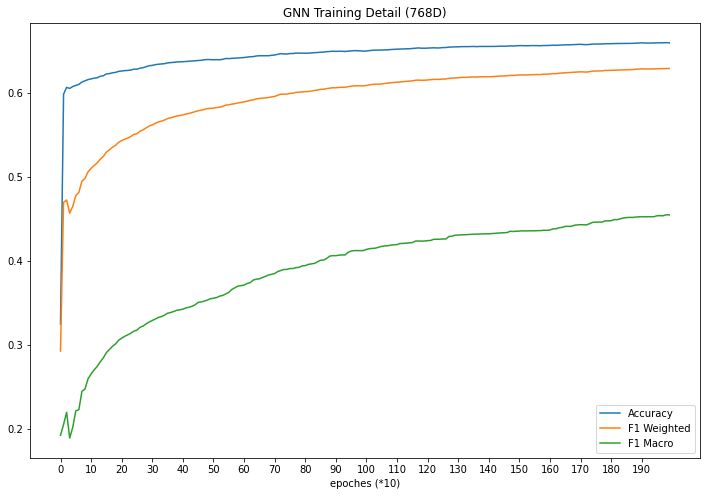

In [40]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (12,8)
plt.plot(list(range(200)), acc_list, label="Accuracy")
plt.plot(list(range(200)), f1_w, label="F1 Weighted")
plt.plot(list(range(200)), f1_m, label="F1 Macro")
plt.legend(loc="lower right")
plt.title("GNN Training Detail (768D)")
plt.xlabel("epoches (*10)")
plt.xticks(np.arange(0, 200, 10))
plt.show()